<a href="https://colab.research.google.com/github/klouderm/DS6290_RMS/blob/main/Assignment4/assign_4_KylieLoudermilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License

Copyright 2021 Kylie Loudermilk (kylieloudermilk@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 4 Template
With two calls to a blackbox prediction API we can craft adversarial examples to manipulate the model toward higher and lower predictions.

#### Imports and inits

In [ ]:
!pip install h2o
!pip install interpret

In [2]:
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.perf import ROC                                    # ROC measure for xgb2
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt14bgotd
  JVM stdout: /tmp/tmpt14bgotd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpt14bgotd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_unknownUser_5bt6ou
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Define Utility Functions

#### Utility function that trains a cross-validated decision tree

In [3]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    # generate graphviz file and then PNG
    get_gv(title, model_id, mojo_path)
    get_png(model_id)

    return tree


#### Utility function that converts h2o MOJO into graphviz file

In [4]:
def get_gv(title, model_id, mojo_path):

    """ Utility function to generate graphviz dot file from h2o MOJO using
        a subprocess.

    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier.
        mojo_path: Path to saved model MOJO (Java scoring artifact);
                   generated by train_cv_dt function above.
    """

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of
    # tree, see for more information:
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    # if the line below fails for you, try instead:
    #gv_args = str('-cp ' + h2o_jar_path +
    #              ' hex.genmodel.tools.PrintMojo --tree 0 -i "'
    #              + mojo_path + '" -o').split()
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', '"' + str(title) + '"']

    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)



#### Utility function that converts graphviz file into PNG

In [5]:
def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    Arg:
        model_id: h2o model identifier.
    """

    gv_file_name = model_id + '.gv'

    # construct call to generate PNG from
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call
    print('Calling external process ...')
    print(' '.join(png_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(png_args, shell=True)
    _ = subprocess.call(png_args)


#### Start global timer

In [6]:
tic = time.time()

In [ ]:
import io
from google.colab import files
from google.colab import drive
uploaded = files.upload() # upload training and test data
import pandas as pd
train = pd.read_csv(io.StringIO(uploaded['hmda_train_preprocessed.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['hmda_test_preprocessed.csv'].decode('utf-8')))
!pip install piml
from piml import Experiment
exp = Experiment()
#exp.data_loader(data=train)

In [8]:
drive.mount('/drive', force_remount=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Mounted at /drive


#### Import data

In [9]:
#data = pd.read_csv('../data/hmda_train_preprocessed.csv')
#test = pd.read_csv('../data/hmda_test_preprocessed.csv')
data=train

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Assign basic modeling roles

In [10]:
y_name = 'high_priced'

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Fit interpretable model

#### Split data into train and validation partitions

In [11]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [12]:
from piml.models import XGB2Classifier

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [13]:
# params dict for remediated models
rem_params = {'n_estimators': 80,
              'max_bin': 20,
              'eta': 0.3,
              'gamma': 0.05,
              'random_state': 12345}

rem_x_names = ['intro_rate_period_std',
               'debt_to_income_ratio_missing',
               'conforming',
               'no_intro_rate_period_std',
               'income_std',
               'debt_to_income_ratio_std',
               'property_value_std',
               'term_360']

rem_xgb2 = XGB2Classifier(**rem_params)
rem_xgb2.fit(train[rem_x_names], train[y_name])
rem_xgb2_perf = ROC(rem_xgb2.predict_proba).explain_perf(valid[rem_x_names].to_numpy(), valid[y_name].to_numpy())
rem_auc = rem_xgb2_perf._internal_obj['overall']['auc']
print('Remediated XGB2 retrained with AUC: %.4f.' % rem_auc)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Remediated XGB2 retrained with AUC: 0.7795.


## Model Extraction Attack

#### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [14]:
# best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_missing': {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame

np.random.seed(SEED) # same results each time cell is run

for j in list(schema_dict.keys()): # loop through features

    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Visualize simulated data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

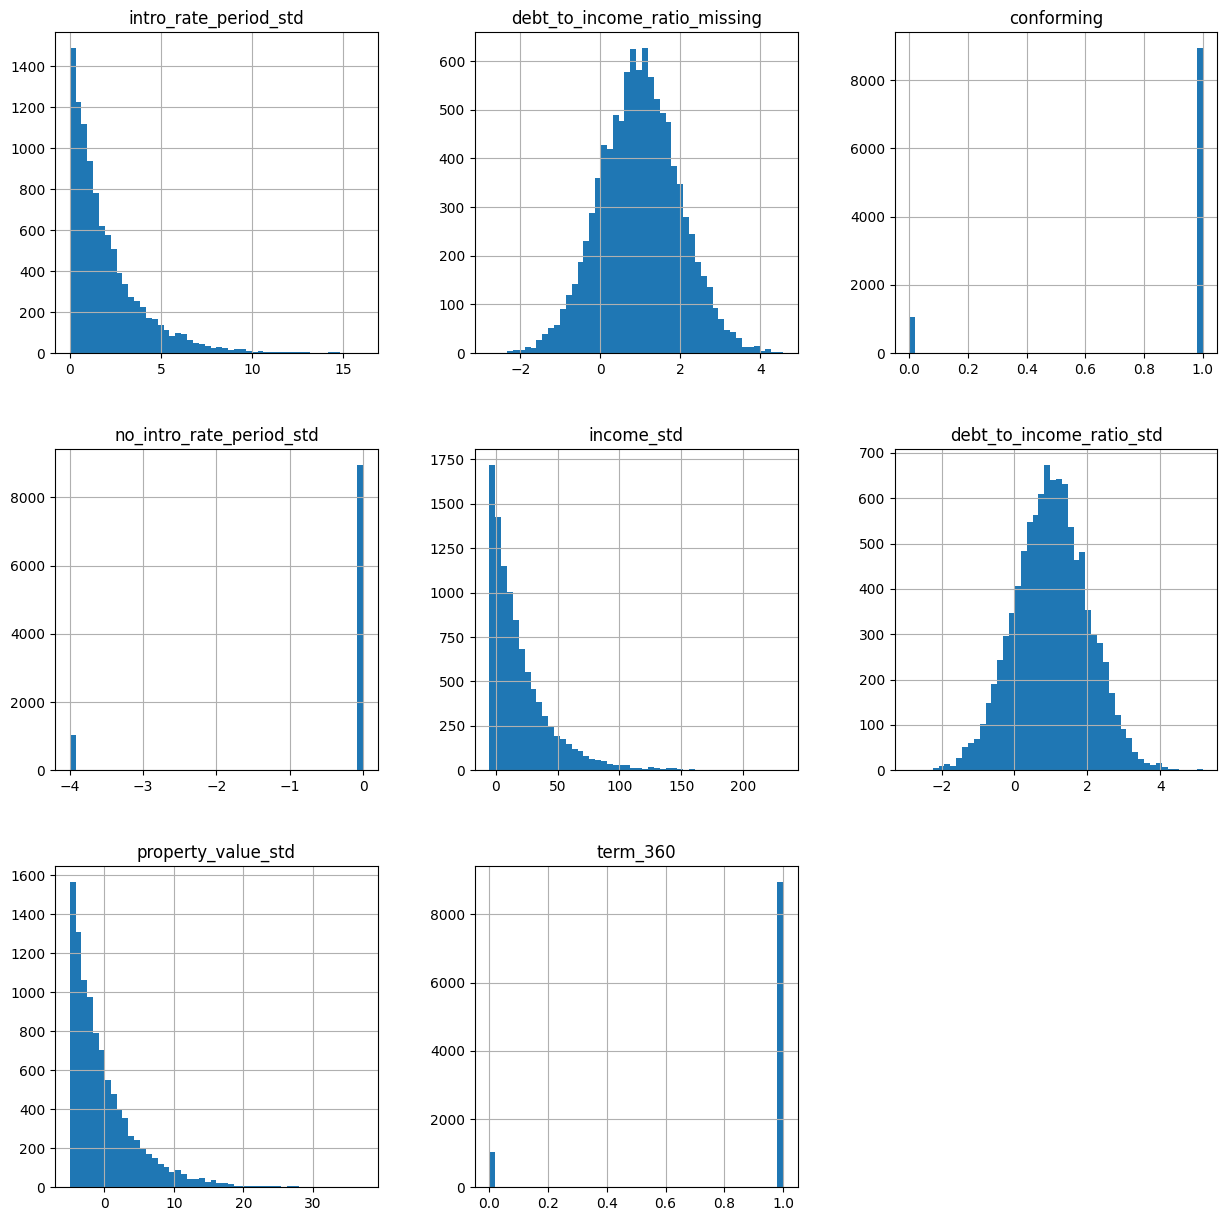

In [15]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [16]:
blackbox_phat = pd.DataFrame(rem_xgb2.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,term_360,conforming,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_missing,debt_to_income_ratio_std,phat
0,0,1,0,2.569741,0.045267,42.240192,0.016488,0.447061,0.005615
1,1,1,-4,10.896060,-2.425113,42.901731,0.721076,0.557710,0.017903
2,1,1,0,1.002831,2.134705,64.499407,-0.607210,0.475470,0.032926
3,1,1,0,2.582480,-4.377945,64.436437,1.166301,0.291567,0.034826
4,1,1,0,0.092319,-0.509713,8.736716,-0.431910,-0.733498,0.054634


#### Extract a stolen decision tree model

In [17]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Generated MOJO path:
 /content/stolen_dt.zip
Discovered H2O jar path:
 /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /content/stolen_dt.zip -o stolen_dt.gv --title "Stolen Model"
Calling external process ...
dot -Tpng stolen_dt.gv -o stolen_dt.png


#### View stolen model
Double clicking should zoom.

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

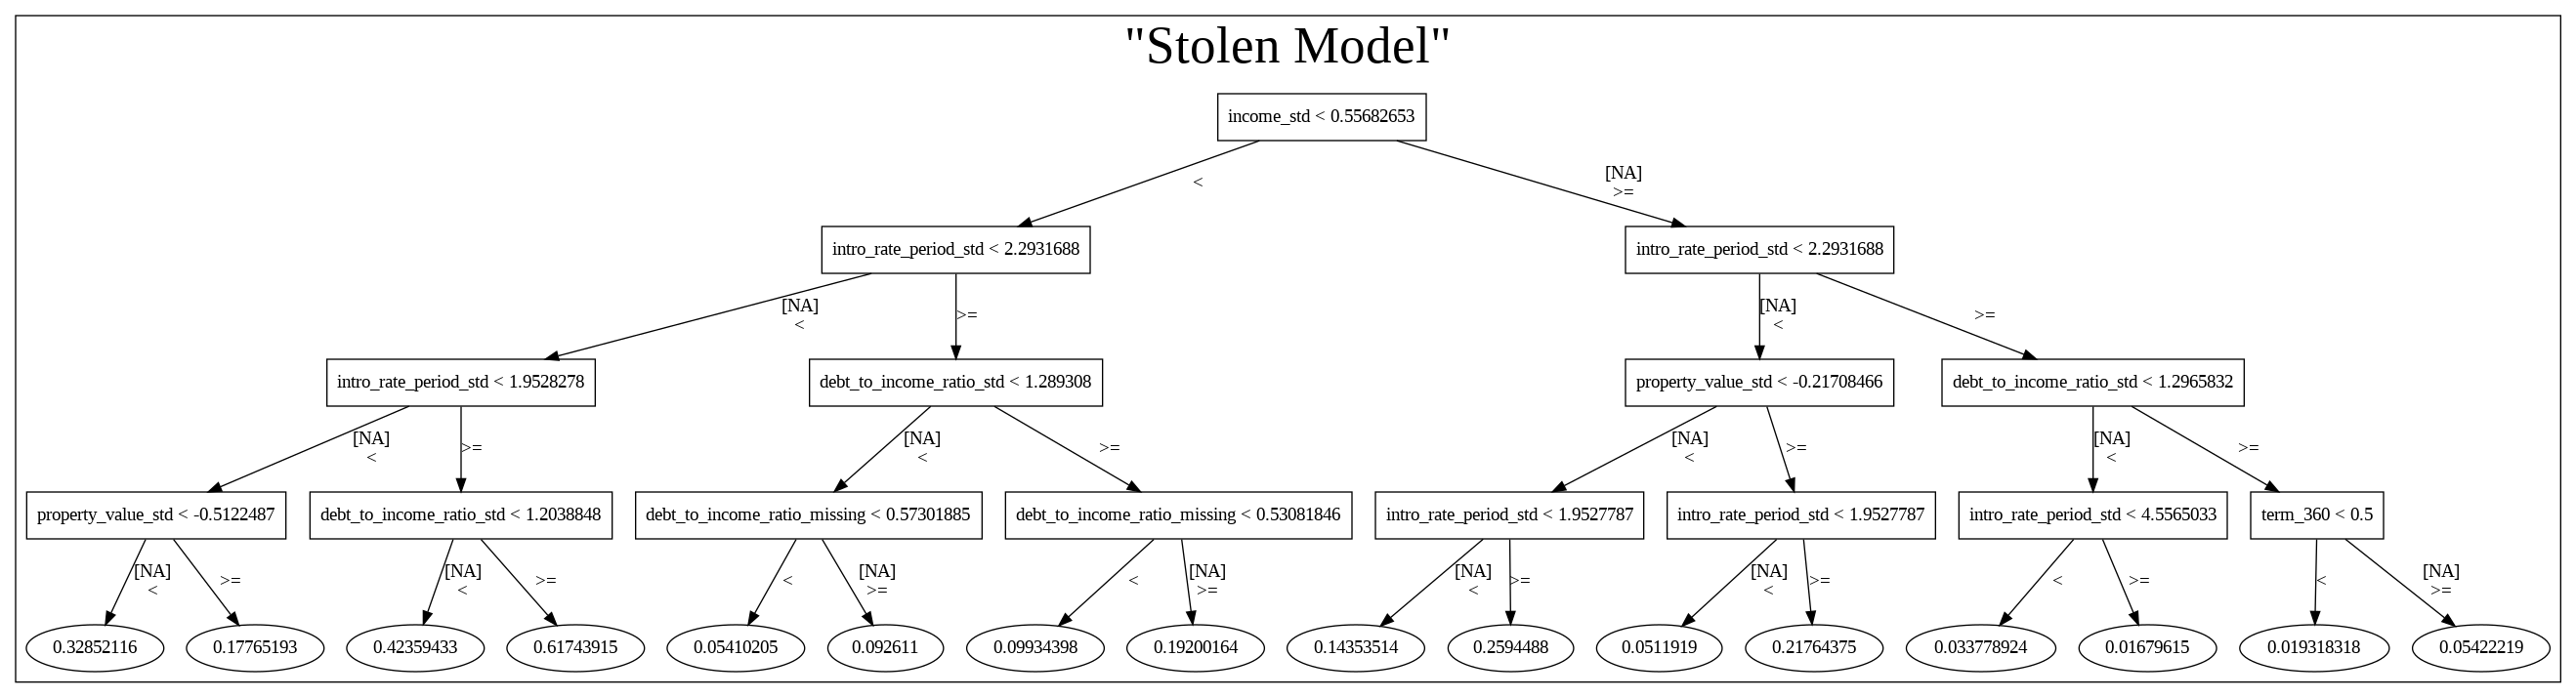

In [18]:
display(Image(('stolen_dt.png')))
# if this is failing, you may need graphviz
# on Colab or linux, install with:
# "!apt-get install graphviz" (inside notebook)
# "apt-get install graphviz" (outside notebook)
# on mac, install with:
# "!brew install graphviz" (inside notebook)
# "brew install graphviz" (outside notebook)

Now an attacker has a basic flow chart for how the XGB2 works. This can be used as a sandbox for subsequent attacks!

#### Variable importance for stolen model

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

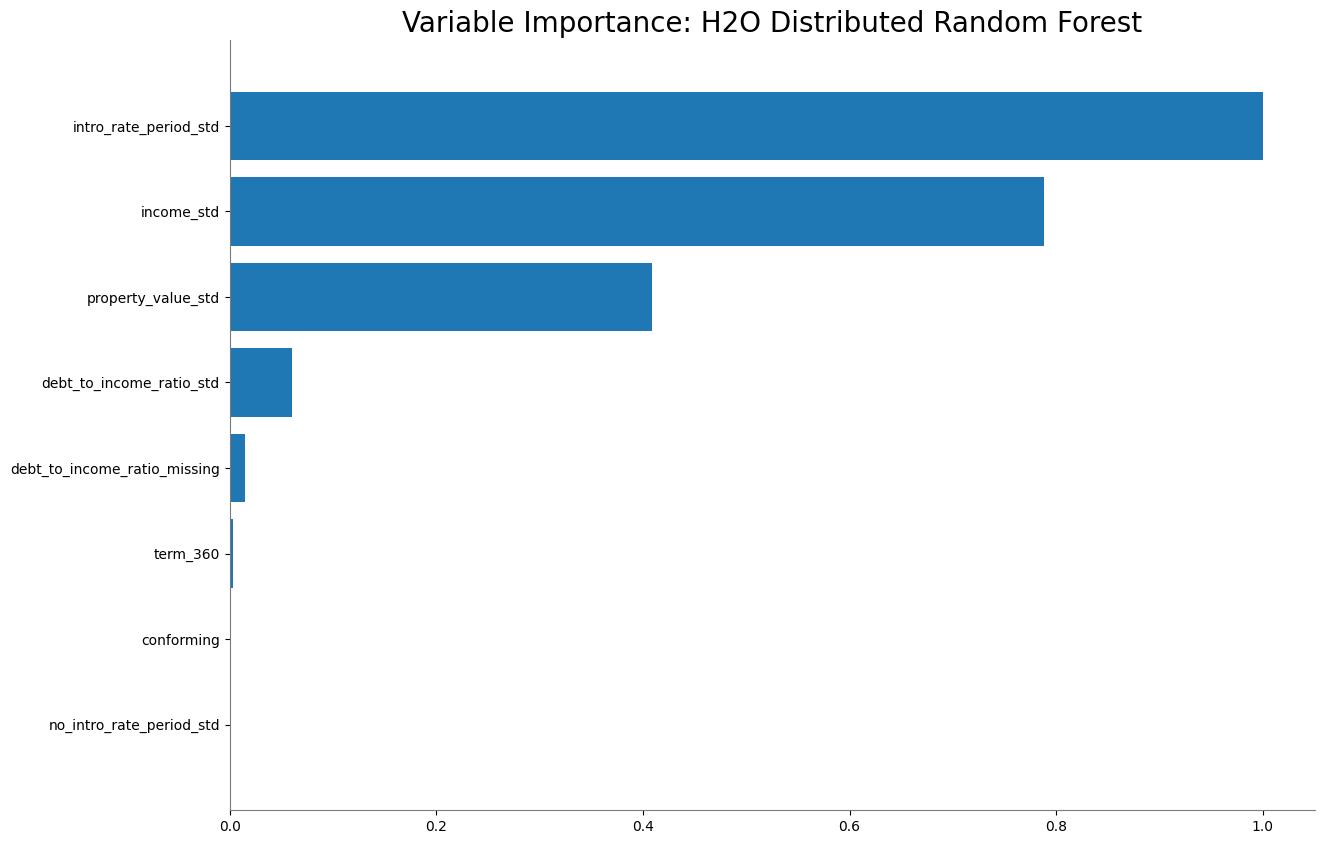

<Figure size 640x480 with 0 Axes>

In [19]:
stolen_dt.varimp_plot()

These are the most important variables in the stolen model, and likely in the real model too.

#### Assess accuracy of stolen model

In [20]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0446125,0.0007216,0.0447,0.0438512,0.0452864
mean_residual_deviance,0.0045117,0.0002339,0.0043934,0.0043606,0.0047811
mse,0.0045117,0.0002339,0.0043934,0.0043606,0.0047811
r2,0.6661988,0.0204156,0.6799667,0.6758868,0.6427428
residual_deviance,0.0045117,0.0002339,0.0043934,0.0043606,0.0047811
rmse,0.0671542,0.0017288,0.0662824,0.0660348,0.0691454
rmsle,0.0547457,0.0013697,0.0541399,0.0537834,0.0563138


## Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [21]:
low_adversary_seed = random_frame.loc[(random_frame['property_value_std'] >= -0.058) &
                                      (random_frame['debt_to_income_ratio_std'] < 1.308) &
                                      (random_frame['intro_rate_period_std'] >= 2.375), :].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['property_value_std'] < -0.647) &
                                       (random_frame['intro_rate_period_std'] < 2.28) &
                                       (random_frame['debt_to_income_ratio_std'] >= 1.3) &
                                       (random_frame['term_360'] >= 0.5), :].mean()
print('High adversarial example search seed row:')
print(high_adversary_seed)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Low adversarial example search seed row:
term_360                         0.887500
conforming                       0.887500
no_intro_rate_period_std        -0.494444
intro_rate_period_std            4.338288
property_value_std               4.821750
income_std                      20.301507
debt_to_income_ratio_missing     0.989544
debt_to_income_ratio_std         0.412839
dtype: float64

High adversarial example search seed row:
term_360                         1.000000
conforming                       0.887262
no_intro_rate_period_std        -0.398243
intro_rate_period_std            0.905242
property_value_std              -3.137136
income_std                      20.473696
debt_to_income_ratio_missing     1.014648
debt_to_income_ratio_std         2.008228
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [22]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

# quantiles over which to search
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                for d in list(random_frame['term_360'].quantile(low_quantiles)):
                    low_adversary_seed['property_value_std'] = a
                    low_adversary_seed['intro_rate_period_std'] = b
                    low_adversary_seed['debt_to_income_ratio_std'] = c
                    low_adversary_seed['term_360'] = d
                    low_adversary_frame = low_adversary_frame.append(low_adversary_seed,
                                                                     ignore_index=True, sort=False)

# view potential low scoring adversarial examples
low_adversary_frame.head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,term_360,conforming,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_missing,debt_to_income_ratio_std
0,0.0,0.8875,-0.494444,9.25508,17.673949,20.301507,0.989544,-1.314512
1,0.0,0.8875,-0.494444,9.25508,17.673949,20.301507,0.989544,-1.314512
2,0.0,0.8875,-0.494444,9.25508,17.673949,20.301507,0.989544,-1.314512
3,1.0,0.8875,-0.494444,9.25508,17.673949,20.301507,0.989544,-1.314512
4,1.0,0.8875,-0.494444,9.25508,17.673949,20.301507,0.989544,-1.314512


#### Perturb seed row to find high scoring adversarial examples

In [23]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                for d in list(random_frame['term_360'].quantile(high_quantiles)):
                    high_adversary_seed['property_value_std'] = a
                    high_adversary_seed['intro_rate_period_std'] = b
                    high_adversary_seed['debt_to_income_ratio_std'] = c
                    high_adversary_seed['term_360'] = d
                    high_adversary_frame = high_adversary_frame.append(high_adversary_seed,
                                                                       ignore_index=True, sort=False)

# view potential high scoring adversarial examples
high_adversary_frame.head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,term_360,conforming,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_missing,debt_to_income_ratio_std
0,1.0,0.887262,-0.398243,0.020961,-4.954563,20.473696,1.014648,3.331848
1,1.0,0.887262,-0.398243,0.020961,-4.954563,20.473696,1.014648,3.331848
2,1.0,0.887262,-0.398243,0.020961,-4.954563,20.473696,1.014648,3.331848
3,1.0,0.887262,-0.398243,0.020961,-4.954563,20.473696,1.014648,3.331848
4,1.0,0.887262,-0.398243,0.020961,-4.954563,20.473696,1.014648,3.331848


#### Second call to blackbox API to test adversarial examples

In [24]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_xgb2.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,term_360,conforming,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_missing,debt_to_income_ratio_std,phat
156,0.0,0.887500,-0.494444,6.103893,10.133455,20.301507,0.989544,-0.622491,0.001167
280,0.0,0.887500,-0.494444,6.103893,6.520001,20.301507,0.989544,-0.622491,0.001167
157,0.0,0.887500,-0.494444,6.103893,10.133455,20.301507,0.989544,-0.622491,0.001167
305,0.0,0.887500,-0.494444,4.684760,6.520001,20.301507,0.989544,-0.622491,0.001167
155,0.0,0.887500,-0.494444,6.103893,10.133455,20.301507,0.989544,-0.622491,0.001167
...,...,...,...,...,...,...,...,...,...
1017,1.0,0.887262,-0.398243,0.020961,-3.595837,20.473696,1.014648,1.688923,0.236744
1016,1.0,0.887262,-0.398243,0.020961,-3.595837,20.473696,1.014648,1.688923,0.236744
1015,1.0,0.887262,-0.398243,0.020961,-3.595837,20.473696,1.014648,1.688923,0.236744
1036,1.0,0.887262,-0.398243,0.102988,-3.595837,20.473696,1.014648,2.325521,0.236744


#### End timer

In [25]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

All tasks completed in 709.73 s.


#### Shutdown H2O

In [26]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_ad20 closed.
